## Import the libraries

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import seaborn as sns
from flask import Flask, jsonify
import os

## Load the dataset from Colab env

In [5]:
file_path = "/content/train.csv"


## Read the Dataset

In [6]:
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError("Dataset not found. Make sure the file is uploaded to the correct path.")

## Data Cleaning and Aggregation

In [7]:
print("Initial Data Information:")
data.info()


Initial Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-nu

## Convert dates to datetime format

In [8]:
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], errors='coerce')

## Fill missing Postal Codes with 0

In [9]:
data['Postal Code'] = data['Postal Code'].fillna(0).astype(int)

## Add a new column for shipping duration

In [10]:
data['Shipping_Duration'] = (data['Ship Date'] - data['Order Date']).dt.days

## Drop rows with invalid dates or missing critical data

In [13]:
data = data.dropna(subset=['Order Date', 'Ship Date', 'Sales'])

## Check and fill missing column

In [14]:
if 'Profit' not in data.columns:
    print("Warning: 'Profit' column not found. Adding a placeholder column with zeros.")
    data['Profit'] = 0

if 'Quantity' not in data.columns:
    print("Warning: 'Quantity' column not found. Adding a placeholder column with ones.")
    data['Quantity'] = 1

<ipython-input-14-9de30993074d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Profit'] = 0
<ipython-input-14-9de30993074d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Quantity'] = 1


## Add profit-to-sales ratio (handling division by zero)

In [15]:
data['Profit_to_Sales'] = data['Profit'] / data['Sales']
data['Profit_to_Sales'] = data['Profit_to_Sales'].replace([np.inf, -np.inf], 0).fillna(0)

<ipython-input-15-c51b4956eca0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Profit_to_Sales'] = data['Profit'] / data['Sales']
<ipython-input-15-c51b4956eca0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Profit_to_Sales'] = data['Profit_to_Sales'].replace([np.inf, -np.inf], 0).fillna(0)


## Aggregated data for optimization

In [17]:
aggregated_data = data.groupby(['Region', 'Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Quantity': 'sum',
    'Shipping_Duration': 'mean'
}).reset_index()

print("Aggregated Data:")
print(aggregated_data.head())

Aggregated Data:
    Region         Category       Sales  Profit  Quantity  Shipping_Duration
0  Central        Furniture  47318.7864       0       121         111.256198
1  Central  Office Supplies  35859.3440       0       399         112.406015
2  Central       Technology  64231.8360       0       116         114.129310
3     East        Furniture  51446.3450       0       171         109.947368
4     East  Office Supplies  52083.3340       0       447         106.411633


## Optimization Model: Linear Programming Example

In [18]:
regions = aggregated_data['Region'].unique()
categories = aggregated_data['Category'].unique()

## Simulated costs and constraints

In [19]:
costs = np.random.randint(10, 50, len(regions))  # Simulated costs per region
demand = np.random.randint(100, 300, len(regions))  # Simulated demand per region
supply = np.random.randint(200, 500, len(regions))  # Simulated supply per region

objective = costs
A_eq = np.eye(len(regions))
b_eq = demand
bounds = [(0, supply[i]) for i in range(len(supply))]

result = linprog(objective, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
print("Optimization Results:")
print(result)


Optimization Results:
        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 29942.0
              x: [ 2.810e+02  1.520e+02  2.640e+02  1.290e+02]
            nit: 0
          lower:  residual: [ 2.810e+02  1.520e+02  2.640e+02  1.290e+02]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          upper:  residual: [ 5.900e+01  3.300e+02  9.900e+01  2.900e+02]
                 marginals: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
          eqlin:  residual: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
                 marginals: [ 4.200e+01  1.900e+01  4.800e+01  2.000e+01]
        ineqlin:  residual: []
                 marginals: []
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0


## Simulation: Demand surge and supply constraints

In [20]:
data['Demand_Surge'] = data['Quantity'] * np.random.uniform(1.1, 1.3, len(data))
data['Supply_Constraint'] = data['Region'].apply(lambda x: 0.8 if x == 'Central' else 1.0)
data['Adjusted_Quantity'] = data['Quantity'] * data['Supply_Constraint']


<ipython-input-20-8bcb190ab5df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Demand_Surge'] = data['Quantity'] * np.random.uniform(1.1, 1.3, len(data))
<ipython-input-20-8bcb190ab5df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Supply_Constraint'] = data['Region'].apply(lambda x: 0.8 if x == 'Central' else 1.0)
<ipython-input-20-8bcb190ab5df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

## Visualization

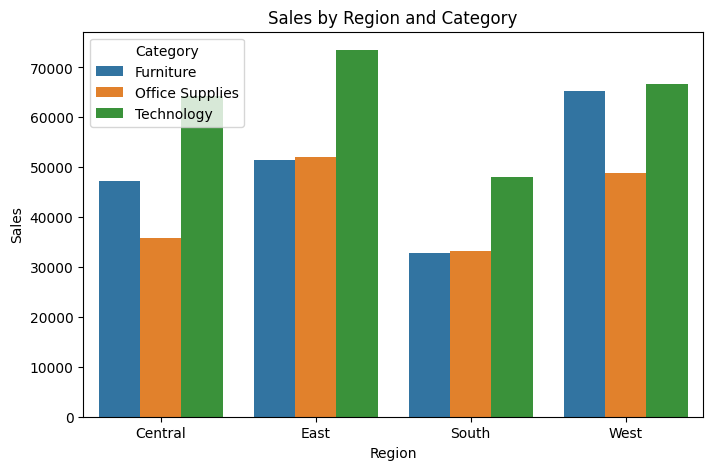

In [21]:
plt.figure(figsize=(8, 5))
sns.barplot(data=aggregated_data, x='Region', y='Sales', hue='Category')
plt.title('Sales by Region and Category')
plt.show()

## Flask

In [27]:
app = Flask(__name__)

@app.route('/aggregated-data', methods=['GET'])
def get_aggregated_data():
    return jsonify(aggregated_data.to_dict(orient='records'))

if __name__ == "__main__":
    app.run(debug=True)


"""
OR if you are using Colab
!pip install flask-ngrok

from flask import Flask, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

@app.route('/aggregated-data', methods=['GET'])
def get_aggregated_data():
    return jsonify(aggregated_data.to_dict(orient='records'))

if __name__ == '__main__':
    app.run()
"""

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


## Save Cleaned Data for Dashboard


In [24]:
cleaned_data_path = "/content/cleaned_data.csv"
data.to_csv(cleaned_data_path, index=False)
print(f"Cleaned data saved to: {cleaned_data_path}")

Cleaned data saved to: /content/cleaned_data.csv
